In [1]:
import os
import csv

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_
from torch.amp import autocast, GradScaler

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR
from torchsummary import summary

from lightning import Fabric


# Set environment variables for PyTorch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Specify which GPU to use, if needed

# PyTorch does not have direct equivalents for some TensorFlow environment settings,
# but you can manage GPU memory growth and logging through PyTorch"s API.

# Disable debug information (PyTorch does not have a direct equivalent, but you can manage logging)
# PyTorch logging can be managed through Python"s logging module or by setting verbosity levels.

# Check if CUDA is available and set device
fabric = Fabric(accelerator="cuda", devices=1, precision="bf16-true")
fabric.launch()

torch.set_float32_matmul_precision('high')

# Print PyTorch version
print(torch.__version__)

# Print number of available GPUs
print("Num GPUs Available: ", torch.cuda.device_count())

# List local devices (PyTorch does not have a direct equivalent, but you can check CUDA devices)
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


2.6.0
Num GPUs Available:  1
Device 0: NVIDIA GeForce RTX 4090


In [2]:
import time
import cv2
import random
import glob
import math

from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from models_torch.segformer_3d import SegFormer3D_SHViT as SegFormer

In [3]:
EPOCHS = [20,2000]

MODEL = "B0"
SHVIT_TYPE = "S4"
DATA_NAME = "SegFormer_shvit_2conv"
DEPTH, HEIGHT, WIDTH = 224, 224, 224
DIM = f"{DATA_NAME}_{DEPTH}x{HEIGHT}x{WIDTH}"
MODEL_NAME = f"{MODEL}_{SHVIT_TYPE}_{DIM}"

LEARNING_RATE = 1e-4
N_CONVS = 2
N_STAGES = 3
BATCH_SIZE = 1
ACCUMULATION_STEPS = 5

USE_RESIZE = False

# images_3d_SegFormer_shvit_2conv_224x224x224
data_path = "../../../../../Documents/Python/shoes_segformer/Data/" 
train_folder = f"{data_path}images_3d_{DIM}/"
valid_folder = f"{data_path}images_3d_{DIM}/"

class_dict = {"Karton": 1, "Außensohle": 2, "Innensohle": 3, "Obermaterial": 4, "Zunge": 5, "Füllmaterial": 6}
# class_dict = {"Außensohle": 1, "Innensohle": 2, "Obermaterial": 3, "Füllmaterial": 4}
N_CLASSES = len(class_dict) + 1 # +Background

In [4]:
# due to the different naming of the shoes (images and masks) we have to create a dict to map the images to an unique id

shoe_img_dict = {"Adidas_Martin-weiss": 1, "Adidas_Martin": 2, 
                 "Bruschi_down2_2_2": 3, "Camper_down2_2_2": 4, 
                 "Citywalk-sit-taupe-34_down2_2_2": 5, "Citywalk-sit-taupe-36_down2_2_2": 6, 
                 "Citywalk-sit-taupe-39_down2_2_2": 7, "Citywalk-sit-taupe-40_down2_2_2": 8, 
                 "Citywalk-sit-taupe-42_down2_2_2": 9, "Herrenschuh_43p5_down2_2_2": 10, 
                 "Lidl_43_down2_2_2": 11, "Lloyd_38_down2_2_2": 12, 
                 "Lloyd_pink_down2_2_2": 13, "Lloyd_weiss_down2_2_2": 14, 
                 "McKinley_Anton_down2_2_2": 15, "Mustang-Sch-Navy-Metalli-35_down2_2_2": 16, 
                 "Mustang-Sch-Navy-Metalli-40_down2_2_2": 17, "Mustang-Sch-Navy-Metalli_31_down2_2_2": 18, 
                 "Mustang-Sch-Navy-Metalli_36_down2_2_2": 19, "Mustang-Sch-Navy-Metalli_37_down2_2_2": 20, 
                 "Pertolio-dunkelbraun_43_down2_2_2": 21, "Petrolio-Sch-dunkelbraun_42_down2_2_2": 22, 
                 "Petrolio-Sch-dunkelbraun_44_down2_2_2": 23, "Petrolio-Sch-dunkelbraun_46_down2_2_2": 24,
                 "PetrolioSch-40-float_down2_2_2": 25, "Puma_38_down2_2_2": 26, 
                 "Puma_Silver_down2_2_2": 27, "Puma_White_down2_2_2": 28, 
                 "Schuh_Martin_down2_2_2": 29, "Shoepassion_40_down2_2_2": 30, 
                 "Shoepassion_45_down2_2_2": 31, "Shoepassion_Herren_40_down2_2_2": 32, 
                 "Sneaker_Dana_Nike": 33, "Sneaker_Dana_Puma_Flyer": 34, 
                 "Stiefel-XY_40_down2_2_2": 35, "Tamaris-Pump-Schwarz-38_down2_2_2": 36, 
                 "Tamaris-Pump-schwarz_36_down2_2_2": 37, "Tamaris-Pump-Schwarz_39_down2_2_2": 38, 
                 "Tamaris-Pump-schwarz_40_down2_2_2": 39, "Tamaris-Pump-schwarz_42_down2_2_2": 40}

shoe_mask_dict = {"Adidas_Martin-weiss": 1, "Adidas_Martin": 2, 
                  "Bruschi_down2_2_2": 3, "Camper_down2_2_2": 4, 
                  "Citywalk 34": 5, "Citywalk 36": 6, 
                  "Citywalk 39": 7, "Citywalk 40": 8, 
                  "Citywalk 42": 9, "Herrenschuh_43p5_down2_2_2": 10, 
                  "Lidl_43_down2_2_2": 11, "Lloyd_38_down2_2_2": 12, 
                  "Lloyd_pink_down2_2_2": 13, "Lloyd_weiss_down2_2_2": 14, 
                  "McKinley_Anton": 15, "Mustang 35": 16, 
                  "Mustang 40": 17, "Mustang 31": 18, 
                  "Mustang 36": 19, "Mustang 37": 20, 
                  "Petrolio 43": 21, "Petrolio 42": 22, 
                  "Petrolio 44": 23, "Petrolio 46": 24, 
                  "Petrolio 40": 25, "Puma_38_down2_2_2": 26, 
                  "Puma_Silver_down2_2_2": 27, "Puma_White_down2_2_2": 28, 
                  "Schuh_Martin_down2_2_2": 29, "Shoepassion_40_down2_2_2": 30, 
                  "Shoepassion_45_down2_2_2": 31, "Shoepassion_Herren_40_down2_2_2": 32, 
                  "Sneaker_Dana_Nike": 33, "Sneaker_Dana_Puma_Flyer": 34, 
                  "StiefelXY": 35, "TamarisPump 38": 36,
                  "TamarisPump 36": 37, "TamarisPump 39": 38, 
                  "TamarisPump 40": 39, "TamarisPump 42": 40}

In [5]:
filenames = glob.glob(os.path.join(train_folder, "volumes/*.npy"))
filenames

['../../../../../Documents/Python/shoes_segformer/Data/images_3d_SegFormer_shvit_2conv_224x224x224/volumes/Adidas_Martin-weiss.npy',
 '../../../../../Documents/Python/shoes_segformer/Data/images_3d_SegFormer_shvit_2conv_224x224x224/volumes/Adidas_Martin.npy',
 '../../../../../Documents/Python/shoes_segformer/Data/images_3d_SegFormer_shvit_2conv_224x224x224/volumes/Bruschi_down2_2_2.npy',
 '../../../../../Documents/Python/shoes_segformer/Data/images_3d_SegFormer_shvit_2conv_224x224x224/volumes/Camper_down2_2_2.npy',
 '../../../../../Documents/Python/shoes_segformer/Data/images_3d_SegFormer_shvit_2conv_224x224x224/volumes/Citywalk-sit-taupe-34_down2_2_2.npy',
 '../../../../../Documents/Python/shoes_segformer/Data/images_3d_SegFormer_shvit_2conv_224x224x224/volumes/Citywalk-sit-taupe-36_down2_2_2.npy',
 '../../../../../Documents/Python/shoes_segformer/Data/images_3d_SegFormer_shvit_2conv_224x224x224/volumes/Citywalk-sit-taupe-39_down2_2_2.npy',
 '../../../../../Documents/Python/shoes_segf

In [6]:
# Extracting the filenames
extracted_filenames = [os.path.basename(filename) for filename in filenames]
print(extracted_filenames)
print(len(extracted_filenames))

['Adidas_Martin-weiss.npy', 'Adidas_Martin.npy', 'Bruschi_down2_2_2.npy', 'Camper_down2_2_2.npy', 'Citywalk-sit-taupe-34_down2_2_2.npy', 'Citywalk-sit-taupe-36_down2_2_2.npy', 'Citywalk-sit-taupe-39_down2_2_2.npy', 'Citywalk-sit-taupe-40_down2_2_2.npy', 'Citywalk-sit-taupe-42_down2_2_2.npy', 'Herrenschuh_43p5_down2_2_2.npy', 'Lidl_43_down2_2_2.npy', 'Lloyd_38_down2_2_2.npy', 'Lloyd_pink_down2_2_2.npy', 'Lloyd_weiss_down2_2_2.npy', 'McKinley_Anton_down2_2_2.npy', 'Mustang-Sch-Navy-Metalli-35_down2_2_2.npy', 'Mustang-Sch-Navy-Metalli-40_down2_2_2.npy', 'Mustang-Sch-Navy-Metalli_31_down2_2_2.npy', 'Mustang-Sch-Navy-Metalli_36_down2_2_2.npy', 'Mustang-Sch-Navy-Metalli_37_down2_2_2.npy', 'Pertolio-dunkelbraun_43_down2_2_2.npy', 'Petrolio-Sch-dunkelbraun_42_down2_2_2.npy', 'Petrolio-Sch-dunkelbraun_44_down2_2_2.npy', 'Petrolio-Sch-dunkelbraun_46_down2_2_2.npy', 'PetrolioSch-40-float_down2_2_2.npy', 'Puma_38_down2_2_2.npy', 'Puma_Silver_down2_2_2.npy', 'Puma_White_down2_2_2.npy', 'Schuh_Marti

In [7]:
class DataGenerator(Dataset):
    def __init__(self, filenames=None, folder_path=None, augment=False, **kwargs):
        super(DataGenerator, self).__init__(**kwargs)
        self.filenames = filenames
        self.folder_path = folder_path
        self.datalen = len(self.filenames)
        self.indexes = np.arange(self.datalen)
        self.augment = augment
        
        
    def loadData(self, file):
        folder = self.folder_path
        
        filename_segs = None
        fn = os.path.join(folder, f"volumes/{file}")
            
        key = os.path.splitext(file)[0]
        if key in shoe_img_dict:
            id = shoe_img_dict[key]
            for key, value in shoe_mask_dict.items():
                if value == id:
                    filename_segs = key
                    break  
                    
        segs = os.path.join(folder, f"masks/{filename_segs}.npy")
            
        vol = np.load(fn)
        min, max = np.min(vol), np.max(vol)
        vol = (vol-min)/(max-min)
        segs = np.load(segs)
        # if self.augment:
        #     v, m = self.random_augment(v, m)
            
        vol = torch.tensor(vol, dtype=torch.float32).unsqueeze(0)
        segs = torch.tensor(segs, dtype=torch.long).unsqueeze(0)
        
        # Apply augmentation if enabled
        if self.augment:
            vol, segs = self.random_augment(vol, segs)        
        
        return vol, segs
    
    
    def random_augment(self, vol, seg):
        # Random flip along the depth axis (axis 1)
        if random.random() > 0.5:
            vol = torch.flip(vol, dims=[1])
            seg = torch.flip(seg, dims=[1])
        
        # Random flip along the height axis (axis 2)
        if random.random() > 0.5:
            vol = torch.flip(vol, dims=[2])
            seg = torch.flip(seg, dims=[2])
            
        # Random flip along the width axis (axis 3)
        if random.random() > 0.5:
            vol = torch.flip(vol, dims=[3])
            seg = torch.flip(seg, dims=[3])
            
        # Define the three possible 2D planes for rotation within the 3D volume.
        # For a tensor of shape [C, D, H, W]:
        #   (1,2): rotation in depth-height plane (i.e., around the width axis)
        #   (1,3): rotation in depth-width plane (i.e., around the height axis)
        #   (2,3): rotation in height-width plane (i.e., around the depth axis)
        planes = [(1, 2), (1, 3), (2, 3)]
        
        # Choose a random plane and number of 90° rotations (k = 0, 1, 2, or 3)
        chosen_plane = random.choice(planes)
        k = random.choice([0, 1, 2, 3])
        
        # Apply the 90° rotation if k is non-zero.
        if k:
            vol = torch.rot90(vol, k, dims=chosen_plane)
            seg = torch.rot90(seg, k, dims=chosen_plane)
        
        return vol, seg
            

    def __getitem__(self, index):
        files = np.array(self.filenames)[index]
        X, y = self.loadData(files)
        return X, y
    
    
    def __len__(self):
        return self.datalen

In [8]:
train_gen = DataGenerator(filenames=extracted_filenames, folder_path=train_folder, augment=True)
val_gen = DataGenerator(filenames=extracted_filenames, folder_path=valid_folder, augment=False)

train_dataloader = DataLoader(train_gen, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_gen, batch_size=BATCH_SIZE, shuffle=False)

val_iter = iter(val_dataloader)

volumes, segs = next(val_iter)
volumes, segs = next(val_iter)
volumes, segs = next(val_iter)

print(volumes.shape, segs.shape)
print(np.unique(segs))

torch.Size([1, 1, 224, 224, 224]) torch.Size([1, 1, 56, 56, 56])
[0 1 2 3 4 5 6]


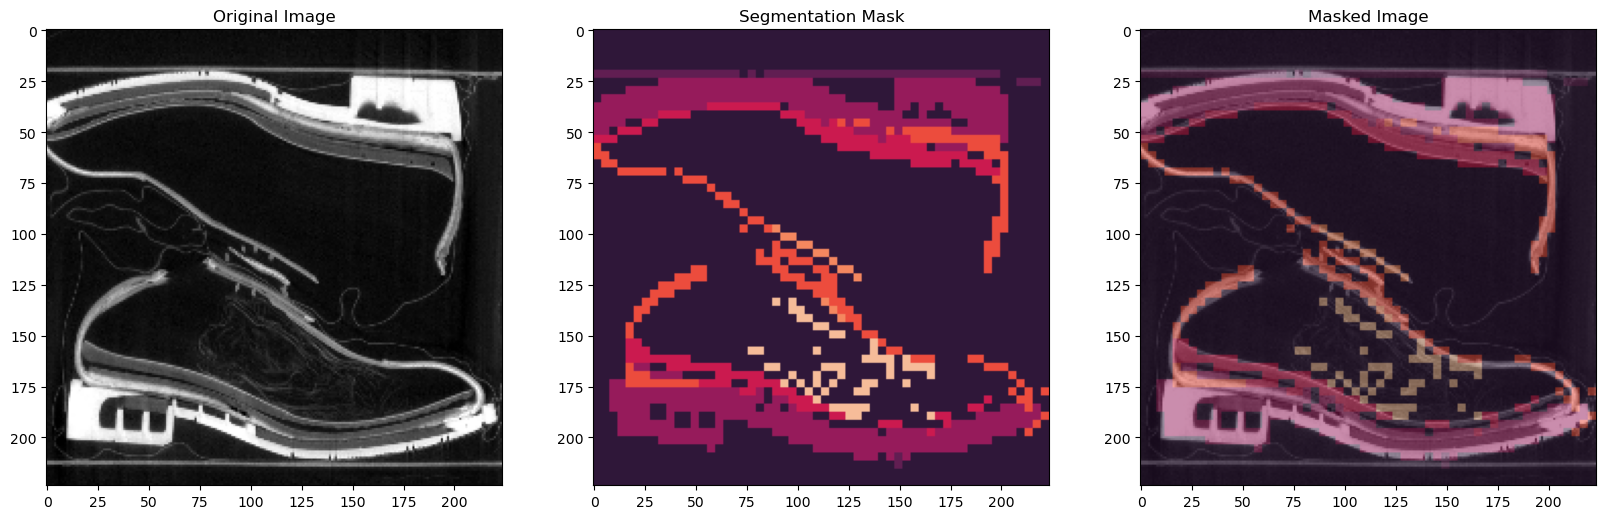

In [9]:
def give_color_to_seg_img(seg, n_classes=N_CLASSES):
    # Initialize a tensor for the colored segmentation image with channels first
    seg_img = torch.zeros((3, seg.shape[1], seg.shape[2]), dtype=torch.float32)
    # colors = sns.color_palette("hls", n_classes)
    colors = sns.color_palette("rocket", n_classes)
    
    seg = seg.squeeze(0) 
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[0,:,:] += segc * colors[c][0]
        seg_img[1,:,:] += segc * colors[c][1]
        seg_img[2,:,:] += segc * colors[c][2]

    return(seg_img)

volumes = volumes.to("cpu")
segs = segs.to("cpu")

idx = 0
volume = volumes[idx].squeeze(0)
seg = segs[idx].squeeze(0)

image = volume[volume.shape[0]//2,:,:]
H, W = image.shape[0], image.shape[1]

seg = seg[seg.shape[0]//2,:,:]
seg = cv2.resize(seg.numpy(), (W, H), interpolation=cv2.INTER_NEAREST) # i.e. StiefelXY: original image and masks have different sizes (968x1130) vs (971x1101) ...
seg = torch.from_numpy(seg).unsqueeze(0)

seg = give_color_to_seg_img(seg)

# Convert tensors to numpy arrays for visualization
image_np = image.numpy()  
seg_np = seg.permute(1, 2, 0).numpy() # Convert from (C, H, W) to (H, W, C)

# Convert tensors to numpy arrays for visualization
masked_image_np = np.stack([image_np] * 3, axis=-1) * 0.5 + seg_np * 0.5

fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image_np, cmap="gray")
axs[0].set_title("Original Image")
axs[1].imshow(seg_np)
axs[1].set_title("Segmentation Mask")
axs[2].imshow(masked_image_np)
axs[2].set_title("Masked Image")
plt.show()

In [10]:
model = SegFormer(model_type=MODEL, shvit_type=SHVIT_TYPE, input_shape=(1, DEPTH, HEIGHT, WIDTH), num_convs=N_CONVS, num_stages=N_STAGES, num_classes=N_CLASSES, use_resize=USE_RESIZE)

In [11]:
def get_model_stats(model):
    # Calculate the size for parameters (weights) and buffers
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    total_size_bytes = param_size + buffer_size
    total_size_mb = total_size_bytes / (1024 ** 2)

    # Count the trainable and non-trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    
    return total_size_mb, trainable_params, non_trainable_params

# Example usage:
model_size, trainable, non_trainable = get_model_stats(model)
print(f"Model size: {model_size:.2f} MB")
print(f"Trainable parameters: {trainable}")
print(f"Non-trainable parameters: {non_trainable}")

Model size: 65.74 MB
Trainable parameters: 17150807
Non-trainable parameters: 0


In [ ]:
# Iterate over the layers of the model
for name, layer in model.named_children():
    print(f"Layer: {name}")
    print(f"  Type: {layer.__class__.__name__}")
    
    for param_name, param in layer.named_parameters(recurse=False):
        print(f" Weight dtype: {param.dtype} | Weight name: {param_name} | Shape: {param.shape}")

Layer: shvit
  Type: SHViT3D
Layer: seg_former_head
  Type: SegFormerHead3D
Layer: resize_layer
  Type: ResizeLayer3D


: 

In [ ]:
import torch
from torchviz import make_dot

# Forward pass through the model to get the graph
model_output = model(volumes)

# # Generate and save the model graph
model_graph = make_dot(model_output, params=dict(model.named_parameters()))
model_graph.render(f"segformer_model_structure_{MODEL_NAME}", format="png")

In [ ]:
# Iterate over the layers of the model
for name, layer in model.named_children():
    # Check if the layer has parameters and print their trainability status
    has_trainable_params = any(param.requires_grad for param in layer.parameters(recurse=False))
    print(f"Layer: {name} | Trainable: {has_trainable_params}")

In [ ]:
def iou_metric(y_true, y_pred, smooth=1, num_classes=N_CLASSES):
    # Flatten y_true
    y_true = y_true.reshape(-1).float()  # Ensure y_true is float32 and flatten

    # Reshape y_pred to match
    y_pred = y_pred.permute(0, 2, 3, 4, 1).reshape(-1,num_classes).float()  # (batch_size * height * width, num_classes)

    iou_per_class = []
    for class_id in range(num_classes):
        true_mask = (y_true == class_id).float()  # Binary mask for class
        pred_mask = y_pred[:, class_id]  # Softmax probability for class

        intersection = torch.sum(true_mask * pred_mask)
        union = torch.sum(true_mask) + torch.sum(pred_mask) - intersection

        iou = (intersection + smooth) / (union + smooth)
        iou_per_class.append(iou)  # Store IoU for each class

    return torch.mean(torch.stack(iou_per_class))

def jaccard_distance_loss(y_true, y_pred, smooth=1, num_classes=N_CLASSES):
    iou = iou_metric(y_true, y_pred, smooth=smooth, num_classes=num_classes)
    return 1 - iou

In [ ]:
class WarmupSchedulerWithReduceLROnPlateau:
    def __init__(self, optimizer, warmup_epochs, initial_lr, target_lr, 
                 reduce_lr_factor=0.1, min_lr=1e-6, patience=5, monitor="val_loss", mode="min"):

        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.initial_lr = initial_lr
        self.target_lr = target_lr
        self.reduce_lr_factor = reduce_lr_factor
        self.patience = patience
        self.min_lr = min_lr
        self.monitor = monitor
        self.mode = mode
        self.epoch = 0
        self.best_metric = np.inf if mode == "min" else -np.inf
        self.wait = 0
        self.last_epoch_metric_value = None
        self.new_lr = None
        for param_group in optimizer.param_groups:
            param_group["lr"] = initial_lr

    def on_epoch_begin(self, epoch):
        if epoch <= self.warmup_epochs:
            # Linear warm-up
            self.new_lr = self.initial_lr + (self.target_lr - self.initial_lr) * (epoch / self.warmup_epochs)
            for param_group in self.optimizer.param_groups:
                param_group["lr"] = self.new_lr
            print(f"Warmup: Setting LR to {self.new_lr:.8f}")
        else:
            for param_group in self.optimizer.param_groups:
                self.new_lr = param_group["lr"]
            print(f"Training: LR = {self.new_lr:.8f} ({self.wait})")

    def on_epoch_end(self, epoch, logs):
        self.epoch += 1
        metric_value = logs.get(self.monitor)

        if metric_value is None:
            return

        if epoch > self.warmup_epochs:
            if (self.mode == "min" and metric_value < self.best_metric) or (self.mode == "max" and metric_value > self.best_metric):
                self.best_metric = metric_value
                self.wait = 0  # Reset patience counter
                # print(f"\nwait (after if): {self.wait}")
            else:
                self.wait += 1
                # print(f"\nwait (after else): {self.wait}")
                if self.wait >= self.patience:
                    self.new_lr = max(self.new_lr * self.reduce_lr_factor, self.min_lr)
                    for param_group in self.optimizer.param_groups:
                        param_group["lr"] = self.new_lr
                    print(f"ReduceLROnPlateau: Reducing LR to {self.new_lr:.8f}")
                    self.wait = 0  # Reset patience counter


class EarlyStopping:
    def __init__(self, patience=50, monitor="val_loss", mode="min"):
        self.patience = patience
        self.monitor = monitor
        self.mode = mode
        self.counter = 0
        self.best_value = np.inf if mode == "min" else -np.inf
        self.early_stop = False

    def __call__(self, logs):
        monitor_value = logs.get(self.monitor)
        if self.mode == "min":
            if monitor_value < self.best_value:
                self.best_value = monitor_value
                self.counter = 0
            else:
                self.counter += 1
        else:
            if monitor_value > self.best_value:
                self.best_value = monitor_value
                self.counter = 0
            else:
                self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True
            

class CSVLogger:
    def __init__(self, filepath, append=False):
        self.filepath = filepath
        if not append and os.path.isfile(filepath):
            os.remove(filepath)
        self.file = open(filepath, "a", newline="")
        self.writer = csv.writer(self.file)
        self.write_header = True        

    def close(self, logs=None):
        self.file.close()

    def __call__(self, epoch=None, logs=None):
        if self.write_header:
            self.writer.writerow(["epoch"] + list(logs.keys()))
            self.write_header = False
        self.writer.writerow([epoch] + list(logs.values()))
        self.file.flush()  # Ensure data is written immediately

        
        
class ModelCheckpoint:
    def __init__(self, filepath, monitor="val_loss", mode="min", save_best_only=True, verbose=1):
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best_value = None
        if self.mode == "min":
            self.best_value = np.inf
        else:
            self.best_value = -np.inf

    def __call__(self, model, logs):
        monitor_value = logs.get(self.monitor)
    
        if not self.save_best_only:
            torch.save(model.state_dict(), self.filepath)
            if self.verbose:
                print(f"\tModel saved to {self.filepath}")
            return

        if self.mode == "min":
            if monitor_value < self.best_value:
                self.best_value = monitor_value
                torch.save(model.state_dict(), self.filepath)
                if self.verbose:
                    print(f"\tModel improved, saving to {self.filepath}")
        else:
            if monitor_value > self.best_value:
                self.best_value = monitor_value
                torch.save(model.state_dict(), self.filepath)
                if self.verbose:
                    print(f"\tModel improved, saving to {self.filepath}")
                    

In [ ]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Start with small LR


scheduler = WarmupSchedulerWithReduceLROnPlateau(optimizer=optimizer, warmup_epochs=EPOCHS[0], 
                                                 initial_lr=1e-8, target_lr=LEARNING_RATE, reduce_lr_factor=0.5, min_lr=1e-8,
                                                 patience=15, monitor="val_loss", mode="min")
early_stopping = EarlyStopping(patience=50, monitor="val_loss", mode="min")
csv_logger = CSVLogger(filepath=f"{MODEL_NAME}_training.log", append=False)
checkpoint = ModelCheckpoint(filepath=f"seg_model_{MODEL_NAME}.pth", monitor="val_loss", mode="min", save_best_only=True, verbose=1)

In [ ]:
train_dataloader = fabric.setup_dataloaders(train_dataloader)
val_dataloader = fabric.setup_dataloaders(val_dataloader)

model, optimizer = fabric.setup(model, optimizer)

In [ ]:
print(volumes.shape, segs.shape)

In [ ]:
max_grad_norm = 1.0

start = time.time()


for epoch in range(EPOCHS[1]):
    
    # At the beginning of the epoch, update the LR if in warmup phase
    scheduler.on_epoch_begin(epoch=epoch)
    
    train_iou, train_loss = 0, 0
    val_iou, val_loss = 0, 0
    step = 0
    
    with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{EPOCHS[1]}", unit="batch", colour="yellow", leave=True) as pbar:    
        start_time = time.time()  # Start timer    
    
        model.train()  # Set the model to training mode
        for batch_idx, (vols, segs) in enumerate(train_dataloader):
            step += 1
            
            output = model(vols)
            loss = jaccard_distance_loss(segs, output)
            train_loss += loss.item()
            fabric.backward(loss)

            if (batch_idx + 1) % ACCUMULATION_STEPS == 0:
                clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()  

            # Update progress bar
            pbar.set_postfix(loss=f"{train_loss / min(step*BATCH_SIZE, len(train_dataloader)):.4f}")
            pbar.update(1)
            
                

        epoch_time = time.time() - start_time  # Calculate time taken                
            
        train_loss /= len(train_dataloader)
        train_iou = 1 - train_loss

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for vols, segs in val_dataloader:
                output = model(vols)
                loss = jaccard_distance_loss(segs, output)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_iou = 1 - val_loss
        
        pbar.set_postfix(loss=f"{train_loss:.4f}, iou={train_iou:.4f}, val_loss={val_loss:.4f}, val_iou={val_iou:.4f}")
        
    
    # Callbacks for CSV_logger
    logs = {"train_loss": train_loss,
        "train_iou": train_iou,
        "val_loss": val_loss,
        "val_iou": val_iou,
        "epoch_time": epoch_time
    }    
    csv_logger(epoch=epoch+1, logs=logs)

    # At the end of the epoch, update the scheduler with the logs
    scheduler.on_epoch_end(epoch=epoch+1, logs=logs)    

    # Check if early stopping condition is met
    early_stopping(logs=logs)    
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break    

    # Save checkpoint file        
    checkpoint(model=model, logs=logs)
    
    
    
csv_logger.close()


end = time.time()

In [ ]:
elapsed = end-start
print(f"Time elapsed {elapsed/60:.2f} min")
print(f"Memory used: {torch.cuda.max_memory_reserved() / 1e9:.02f} GB")

In [ ]:
log_file = f"{MODEL_NAME}_training.log"
data = pd.read_csv(log_file)

# Plot Losses (training and validation)
plt.figure(figsize=(10, 5))
plt.plot(data["epoch"], data["train_loss"], label="Train Loss")
plt.plot(data["epoch"], data["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot IoU (training and validation)
plt.figure(figsize=(10, 5))
plt.plot(data["epoch"], data["train_iou"], label="Train IoU")
plt.plot(data["epoch"], data["val_iou"], label="Validation IoU")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("Training and Validation IoU")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
bestmodel = SegFormer(model_type=MODEL, shvit_type=SHVIT_TYPE, input_shape=(1, DEPTH, HEIGHT, WIDTH), num_convs=N_CONVS, num_stages=N_STAGES, num_classes=N_CLASSES, use_resize=USE_RESIZE)

state_dict = torch.load(f"seg_model_{MODEL_NAME}.pth", map_location=torch.device("cuda"))  # or map to device if needed
bestmodel.load_state_dict(state_dict)

bestmodel = fabric.setup(bestmodel) # Move the model to the appropriate device (GPU if available)

test_gen = DataGenerator(filenames=extracted_filenames, folder_path=valid_folder, augment=False)
test_dataloader = DataLoader(test_gen, batch_size=1, shuffle=False)
test_dataloader = fabric.setup_dataloaders(test_dataloader)

In [ ]:
test_iter = iter(test_dataloader)


for i in range(40):
    vol, seg = next(test_iter)
    
    bestmodel.eval()
    pred = bestmodel(vol).cpu().detach().numpy()

    vol = vol[0].squeeze(0).cpu().detach().numpy()
    seg = seg[0].squeeze(0).cpu().detach().numpy()

    print(vol.shape, seg.shape, pred[0].shape)
    
    image = vol[vol.shape[0]//2,:,:]
    H, W = image.shape[0], image.shape[1]    
    seg = seg[seg.shape[0]//2,:,:]


    pred = np.argmax(pred[0], axis=0)
    pred = pred[pred.shape[0]//2,:,:]
  
    seg = cv2.resize(seg, (W, H), interpolation=cv2.INTER_NEAREST) # i.e. StiefelXY: original image and masks have different sizes (968x1130) vs (971x1101) ...
    pred = cv2.resize(pred, (W, H), interpolation=cv2.INTER_NEAREST) # i.e. StiefelXY: original image and masks have different sizes (968x1130) vs (971x1101) ...
    
    seg = torch.from_numpy(seg).unsqueeze(0)
    pred = torch.from_numpy(pred).unsqueeze(0)

    _s = give_color_to_seg_img(seg).permute(1, 2, 0).numpy()
    _p = give_color_to_seg_img(pred).permute(1, 2, 0).numpy()
    
    # Convert tensors to numpy arrays for visualization
    image = image
    predimg = cv2.addWeighted(np.stack([image]*3, axis=-1), 0.15, _p, 0.85, 0)
    trueimg = cv2.addWeighted(np.stack([image]*3, axis=-1), 0.15, _s, 0.85, 0)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.title("Original")
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    
    plt.subplot(132)
    plt.title("Prediction")
    plt.imshow(predimg)
    plt.axis("off")
    
    plt.subplot(133)
    plt.title("Ground truth")
    plt.imshow(trueimg)
    plt.axis("off")
    plt.tight_layout()
    # plt.savefig("pred_"+str(i)+".png", dpi=150)
    plt.show()